In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

In [2]:
def find_closest_number(sorted_array, target):
    # Ensure the array is a NumPy array
    sorted_array = np.asarray(sorted_array)
    
    # Find the index of the closest number using binary search
    idx = np.searchsorted(sorted_array, target, side="left")
    
    # Determine if the closest number is the one on the left or right
    if idx > 0 and (idx == len(sorted_array) or abs(sorted_array[idx-1] - target) <= abs(sorted_array[idx] - target)):
        return sorted_array[idx-1]
    else:
        return sorted_array[idx]

In [3]:
def generate_prime_composite_graph(n: int):
    neighbors_by_node = [[] for _ in range(n+1)]

    primes = [2]
    composites = []

    for i in range(3,n+1):
        is_prime = True
        j = i
        for prime in primes:
            if j == 1:
                break 
            while j % prime == 0:
                is_prime = False
                neighbors_by_node[prime].append(i)
                neighbors_by_node[i].append(prime)
                j/=prime

        if is_prime:
            primes.append(i)
        else:
            composites.append(i)


    neighbors_by_primes = [neighbors_by_node[i] for i in primes]
    neighbors_by_composites = [neighbors_by_node[i] for i in composites]

    return neighbors_by_node, neighbors_by_primes, neighbors_by_composites, np.array(primes), np.array(composites)


def model_prime_composite_graph(n: int):
    neighbors_by_node = [[] for _ in range(n+1)]

    primes = [2]
    composites = []
    
    for i in range(3,n+1):
        connected = False
        R_m = 2
        n = i
        R_M = np.sqrt(n)
        for p in primes:

            if p > np.sqrt(i):
                break

            if random.random() < 1/p:
                connected = True

                neighbors_by_node[p].append(i)
                neighbors_by_node[i].append(p)

                R_m = p
                n = n/p
                R_M = np.sqrt(n)
                break

        if not connected:
            primes.append(i)

        else:
            composites.append(i)

            while connected:
                connected = False

                for p in primes:
                    if p < R_m or p > R_M:
                        break

                    if random.random() < 1/p:
                        connected = True

                        neighbors_by_node[p].append(i)
                        neighbors_by_node[i].append(p)

                        R_m = p
                        n = n/p
                        R_M = np.sqrt(n)

            nearest = find_closest_number(sorted_array=primes, target=R_M*R_M)
            neighbors_by_node[nearest].append(i)
            neighbors_by_node[i].append(nearest)

    neighbors_by_primes = [neighbors_by_node[i] for i in primes]
    neighbors_by_composites = [neighbors_by_node[i] for i in composites]

    return neighbors_by_node, neighbors_by_primes, neighbors_by_composites, np.array(primes), np.array(composites)

In [4]:
def degree_distribution(neighbors_by_node, neighbors_by_primes, neighbors_by_composites):

    neighbors_by_node = neighbors_by_node[2:]
    degrees_by_node = [len(x) for x in neighbors_by_node]


    degrees = [x for x in set(degrees_by_node)]


    degree_distribution = [degrees_by_node.count(x) for x in degrees]
    degree_distribution = degree_distribution/np.sum(degree_distribution)
  

    degrees_by_primes = [len(x) for x in neighbors_by_primes]


    primes_degrees = [x for x in set(degrees_by_primes)]

    primes_degree_distribution = [degrees_by_primes.count(x) for x in primes_degrees]
    primes_degree_distribution = primes_degree_distribution/np.sum(primes_degree_distribution)
    
    
    degrees_by_composites = [len(x) for x in neighbors_by_composites]

    composites_degrees = [x for x in set(degrees_by_composites)]

    composites_degree_distribution = [degrees_by_composites.count(x) for x in composites_degrees]
    composites_degree_distribution = composites_degree_distribution/np.sum(composites_degree_distribution)

    

    return np.array(degrees), np.array(degree_distribution), np.array(primes_degrees), np.array(primes_degree_distribution), np.array(composites_degrees), np.array(composites_degree_distribution)



def weight_distribution(neighbors_by_node):

    neighbors_by_node = neighbors_by_node[2:]

    weights_elements = [count for i in range(len(neighbors_by_node)) for count in (Counter(neighbors_by_node[i]).values() if len(neighbors_by_node[i]) > 0 else [0])]
    weights = [x for x in set(weights_elements) if x > 0]

    weight_distribution = [weights_elements.count(x) for x in weights]
    weight_distribution = weight_distribution/np.sum(weight_distribution)

    return weights, weight_distribution

                

In [5]:
def cumulate(d, dd, pd, pdd, cd, cdd):
    d_c = np.arange(max(d)+1)
    pd_c = np.arange(max(pd)+1)
    cd_c = np.arange(max(cd)+1)

    dd_c = np.zeros_like(d_c, dtype=float)

    for i, d_i in enumerate(d):
        dd_c[d_i] = dd[i]

    pdd_c = np.zeros_like(pd_c, dtype=float)
    for i, pd_i in enumerate(pd):
        pdd_c[pd_i] = pdd[i]

    cdd_c = np.zeros_like(cd_c, dtype=float)
    for i, cd_i in enumerate(cd):
        cdd_c[cd_i] = cdd[i]


    dd_c = [np.sum(dd_c[i:]) for i in range(len(dd_c))]
    pdd_c = [np.sum(pdd_c[i:]) for i in range(len(pdd_c))]
    cdd_c = [np.sum(cdd_c[i:]) for i in range(len(cdd_c))]

    return d_c, dd_c, pd_c, pdd_c, cd_c, cdd_c

In [6]:
def average_model(numbers: int, times: int):
    avg_dd = np.zeros(100000, dtype=float)
    avg_pdd = np.zeros(100000, dtype=float)
    avg_cdd = np.zeros(100000, dtype=float)

    avg_wd = np.zeros(1000, dtype=float)

    max_w = 0

    max_d = 0
    max_pd = 0
    max_cd = 0

    for _ in range(times):
        nbn, nbp, nbc, primes, composites = model_prime_composite_graph(numbers)
        d, dd, pd, pdd, cd, cdd = degree_distribution(nbn, nbp, nbc)

        w, wd = weight_distribution(nbn)

        max_w = max(max_w, max(w))

        for i, w_i in enumerate(w):
            avg_wd[w_i] += wd[i]
        
        max_d = max(max_d, max(d))
        max_pd = max(max_pd, max(pd))
        max_cd = max(max_cd, max(cd))

        for i, d_i in enumerate(d):
            avg_dd[d_i] += dd[i]

        for i, pd_i in enumerate(pd):
            avg_pdd[pd_i] += pdd[i]

        for i, cd_i in enumerate(cd):
            avg_cdd[cd_i] += cdd[i]

    avg_w = np.arange(max_w+1)
    avg_wd = avg_dd[:max_w+1]/times

    avg_d = np.arange(max_d+1)
    avg_pd = np.arange(max_pd+1)
    avg_cd = np.arange(max_cd+1)

    avg_dd = avg_dd[:max_d+1]/times
    avg_pdd = avg_pdd[:max_pd+1]/times
    avg_cdd = avg_cdd[:max_cd+1]/times

    avg_dd_c = [np.sum(avg_dd[i:]) for i in range(len(avg_dd))]
    avg_pdd_c = [np.sum(avg_pdd[i:]) for i in range(len(avg_pdd))]
    avg_cdd_c = [np.sum(avg_cdd[i:]) for i in range(len(avg_cdd))]


    return avg_d, avg_dd, avg_pd, avg_pdd, avg_cd, avg_cdd, avg_dd_c, avg_pdd_c, avg_cdd_c, avg_w, avg_wd
    # avg_w, avg_wd

In [7]:
nbn, nbp, nbc, primes, composites = generate_prime_composite_graph(100_000)

In [8]:
d, dd, pd, pdd, cd, cdd = degree_distribution(nbn, nbp, nbc)

In [9]:
w, wd = weight_distribution(nbn)

In [10]:
d_c, dd_c, pd_c, pdd_c, cd_c, cdd_c = cumulate(d, dd, pd, pdd, cd, cdd)


In [11]:
m_d, m_dd, m_pd, m_pdd, m_cd, m_cdd, m_dd_c, m_pdd_c, m_cdd_c, m_w, m_wd = average_model(100_000, 100)

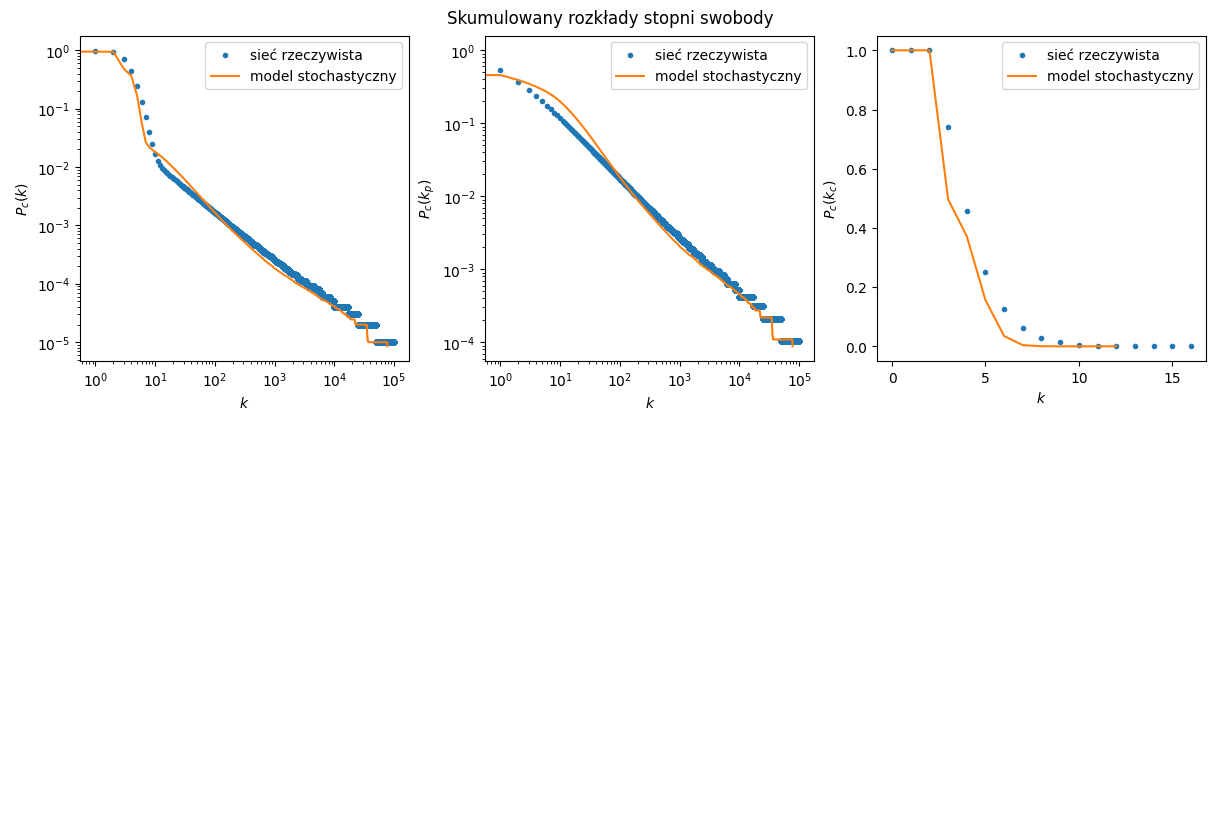

In [36]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
fig.suptitle("Skumulowany rozkłady stopni swobody")
subfigs = fig.subfigures(nrows=2, ncols=1) 

# axs = subfigs[0].subplots(1,3)
# axs[0].set_ylabel(r'$P(k)$')
# axs[1].set_ylabel(r'$P(k_p)$')
# axs[2].set_ylabel(r'$P(k_c)$')

# axs[0].set_xlabel(r'$k$')
# axs[1].set_xlabel(r'$k$')
# axs[2].set_xlabel(r'$k$')

# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[0].plot(d, dd, 'o', markersize=3, , labbel="sieć rzeczywista")
# axs[1].plot(pd, pdd, 'o', markersize=3, label="sieć rzeczywista")
# axs[2].plot(cd, cdd, 'o', markersize=3, label="sieć rzeczywista")
# axs[0].plot(m_d, m_dd, markersize=3, label="model stochastyczny")
# axs[1].plot(m_pd, m_pdd, markersize=3, label="model stochastyczny")
# axs[2].plot(m_cd, m_cdd, markersize=3, label="model stochastyczny")

axs = subfigs[0].subplots(1,3)
axs[0].set_ylabel(r'$P_c(k)$')
axs[1].set_ylabel(r'$P_c(k_p)$')
axs[2].set_ylabel(r'$P_c(k_c)$')

axs[0].set_xlabel(r'$k$')
axs[1].set_xlabel(r'$k$')
axs[2].set_xlabel(r'$k$')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].plot(d_c, dd_c, 'o', markersize=3, label="sieć rzeczywista")
axs[1].plot(pd_c, pdd_c, 'o', markersize=3, label="sieć rzeczywista")
axs[2].plot(cd_c, cdd_c, 'o', markersize=3, label="sieć rzeczywista")
axs[0].plot(m_d[:-3000], m_dd_c[:-3000], markersize=3, label="model stochastyczny")
axs[1].plot(m_pd[:-3000], m_pdd_c[:-3000], markersize=3, label="model stochastyczny")
axs[2].plot(m_cd, m_cdd_c, markersize=3, label="model stochastyczny")

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

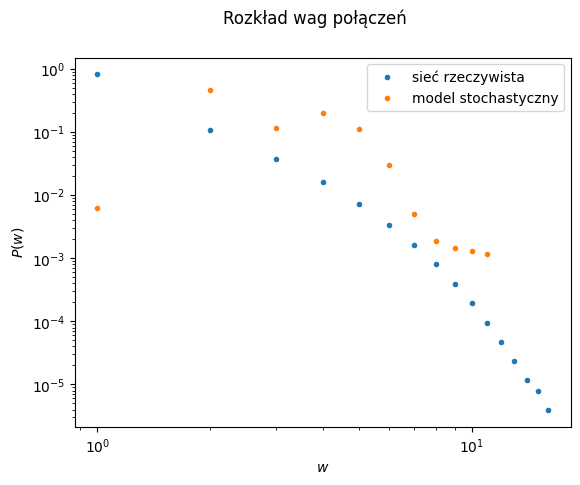

In [38]:
fig, ax = plt.subplots()
fig.suptitle("Rozkład wag połączeń")

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$P(w)$')


ax.plot(w, wd, 'o', markersize=3, label="sieć rzeczywista")
ax.plot(m_w, m_wd, 'o', markersize=3, label="model stochastyczny")
plt.legend()
plt.show()